In [15]:
import colorizerutils as utils
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

tf.__version__

'2.8.0'

In [16]:
# Limit tensorflow vram usage
vram = 14 # GB

gpus = tf.config.list_physical_devices('GPU')

tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=vram*1024)])
print(len(gpus), "Physical GPUs Configured")

# Set tensorflow random seed
tf.random.set_seed(42)

1 Physical GPUs Configured


In [17]:
def make_generator(image_size=64):
    
    # Input layer
    inputs = layers.Input(shape=(image_size,image_size,1))

    # First convolutional block
    down1 = layers.Conv2D(32,kernel_size=(5,5),padding='same')(inputs)
    down1 = layers.BatchNormalization()(down1)
    down1 = layers.LeakyReLU()(down1)
    down1 = layers.Conv2D(32,kernel_size=(5,5),padding='same')(down1)
    down1 = layers.BatchNormalization()(down1)
    down1 = layers.LeakyReLU()(down1)

    # Second convolutional block
    down2 = layers.Conv2D(64,kernel_size=(5,5),padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)
    down2 = layers.Conv2D(64,kernel_size=(5,5),padding='same')(down2)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    # Third convolutional block
    down3 = layers.Conv2D(128,kernel_size=(7,7),padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)
    down3 = layers.Conv2D(128,kernel_size=(7,7),padding='same')(down3)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)

    # Unet bottom layer
    bottleneck = layers.Conv2D(256,kernel_size=(7,7),padding='same',activation='tanh')(down3)
    bottleneck = layers.BatchNormalization()(bottleneck)

    # Third deconvolutional block
    up3 = layers.Concatenate()([bottleneck,down3])
    up3 = layers.Conv2DTranspose(128,kernel_size=(7,7),padding='same')(up3)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.LeakyReLU()(up3)
    up3 = layers.Conv2DTranspose(128,kernel_size=(7,7),padding='same')(up3)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.LeakyReLU()(up3)

    # Second deconvolutional block
    up2 = layers.Concatenate()([up3,down2])
    up2 = layers.Conv2DTranspose(64,kernel_size=(5,5),padding='same')(up2)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.LeakyReLU()(up2)
    up2 = layers.Conv2DTranspose(64,kernel_size=(5,5),padding='same')(up2)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.LeakyReLU()(up2)

    # First deconvolutional block
    up1 = layers.Concatenate()([up2,down1])
    up1 = layers.Conv2DTranspose(32,kernel_size=(5,5),padding='same')(up1)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.LeakyReLU()(up1)
    up1 = layers.Conv2DTranspose(32,kernel_size=(5,5),padding='same')(up1)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.LeakyReLU()(up1)

    # Output two channels (a and b)
    outputs = layers.Conv2DTranspose(2,kernel_size=(5,5),padding='same',activation='relu')(up1)

    model = keras.models.Model(inputs,outputs)
    return model

In [18]:
def make_discriminator(image_size=64):

    model = keras.Sequential()

    # Input two channels (a and b)
    model.add(layers.Conv2D(16,kernel_size=(5,5),padding='same',input_shape=(image_size,image_size,2)))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D())

    # Second convolutional block
    model.add(layers.Conv2D(32,kernel_size=(5,5),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D())

    # Third convolutional block
    model.add(layers.Conv2D(64,kernel_size=(5,5),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D())

    # Fourth convolutional block
    model.add(layers.Conv2D(128,kernel_size=(5,5),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D())

    # Fully connected classifier
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(512))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(16))
    model.add(layers.LeakyReLU())

    # Output probability the image is real
    model.add(layers.Dense(1,activation='sigmoid'))

    return model

In [19]:
# Make the generator with input size (64x64) and optimizer
generator = make_generator(image_size=64)
generator_optimizer = optimizers.Adam(0.0005)

# Tensorboard tracking for the generator
gen_loss_tracker = metrics.Mean('gen_loss',dtype=tf.float32)
gen_dir = 'logs/adv_generator'
gen_summary_writer = tf.summary.create_file_writer(gen_dir)

# Make the discriminator with input size (64x64) and optimizer
discriminator = make_discriminator(image_size=64)
discriminator_optimizer = optimizers.Adam(0.0005)

# Tensorboard tracking for the discriminator
disc_loss_tracker = metrics.Mean('disc_loss',dtype=tf.float32)
disc_dir = 'logs/adv_discriminator'
disc_summary_writer = tf.summary.create_file_writer(disc_dir)

In [20]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 64, 64, 32)   832         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_13 (BatchN  (None, 64, 64, 32)  128         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_19 (LeakyReLU)     (None, 64, 64, 32)   0           ['batch_normalization_13[0]

In [21]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 64, 64, 16)        816       
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        12832     
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                  

In [22]:
def discriminator_loss(real_output, fake_output):
    cross_entropy = losses.BinaryCrossentropy()
    
    # Discriminator output for real images should be one
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)

    # Discriminator output for generated images should be zero
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)

    total_loss = real_loss + fake_loss   
    return total_loss

def generator_loss(fake_output):
    cross_entropy = losses.BinaryCrossentropy()

    # Fake output variable is discriminator output on fake images
    # Generator wants discriminator to classify generated images as real (1)
    total_loss = cross_entropy(tf.ones_like(fake_output),fake_output)
    return total_loss

In [23]:
@tf.function
def gen_step(gray_batch):

    with tf.GradientTape() as gen_tape:

        # Generate a batch of fake images
        generated_batch = generator(gray_batch,training=True)

        # Get discriminator output for batch of generated images
        generated_disc_output = discriminator(generated_batch,training=False)

        # Calculate generator loss based on discriminator output
        gen_loss = generator_loss(generated_disc_output)
    
    # Train generator
    generator_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    
    # Update tensorboard tracker
    gen_loss_tracker(gen_loss)

In [24]:
@tf.function
def disc_step(gray_batch,color_batch):
    
    with tf.GradientTape() as disc_tape:

        # Generate a batch of fake images
        generated_batch = generator(gray_batch,training=False)

        # Get discriminator output for batch of generated images
        generated_disc_output = discriminator(generated_batch,training=True)

        # Get discriminator output for batch of real images
        real_disc_output = discriminator(color_batch,training=True)

        # Calculate discriminator loss based on outputs
        disc_loss = discriminator_loss(real_disc_output,generated_disc_output)
    
    # Train discriminator
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

    # Update tensorboard tracker
    disc_loss_tracker(disc_loss)

In [25]:
def train_model(epochs,dataset):
    
    for epoch in tqdm(range(epochs)):
        
        # Run discriminator training step
        for gray_batch,color_batch in dataset:
            disc_step(gray_batch,color_batch)

        # Write results to tensorboard
        with disc_summary_writer.as_default():
            tf.summary.scalar('disc_loss',disc_loss_tracker.result(),step=epoch)

        # Run generator training step
        for gray_batch,color_batch in dataset:
            gen_step(gray_batch)

        # Write results to tensorboard
        with gen_summary_writer.as_default():
            tf.summary.scalar('gen_loss',gen_loss_tracker.result(),step=epoch)

        # Reset tensorboard trackers every epoch
        disc_loss_tracker.reset_states()
        gen_loss_tracker.reset_states()

In [26]:
train_dir = '../images/train_images/'
test_dir = '../images/test_images/'

# Load 10000 training images
train_images = utils.load_images(10000,image_size=64,image_dir=train_dir)

# Split training images into channels and make a tensorflow dataset
X_train, y_train = utils.rgb_to_lab_split_channels(train_images)
train_dataset = utils.make_dataset(X_train,y_train)

# Load 20 testing images
test_images = utils.load_images(20,image_size=64,image_dir=test_dir)

# Split testing images into channels
X_test, y_test = utils.rgb_to_lab_split_channels(test_images)

In [27]:
# Train the generator and discriminator
train_model(epochs=25,dataset=train_dataset)

100%|██████████████████████████████████████████| 25/25 [56:18<00:00, 135.12s/it]


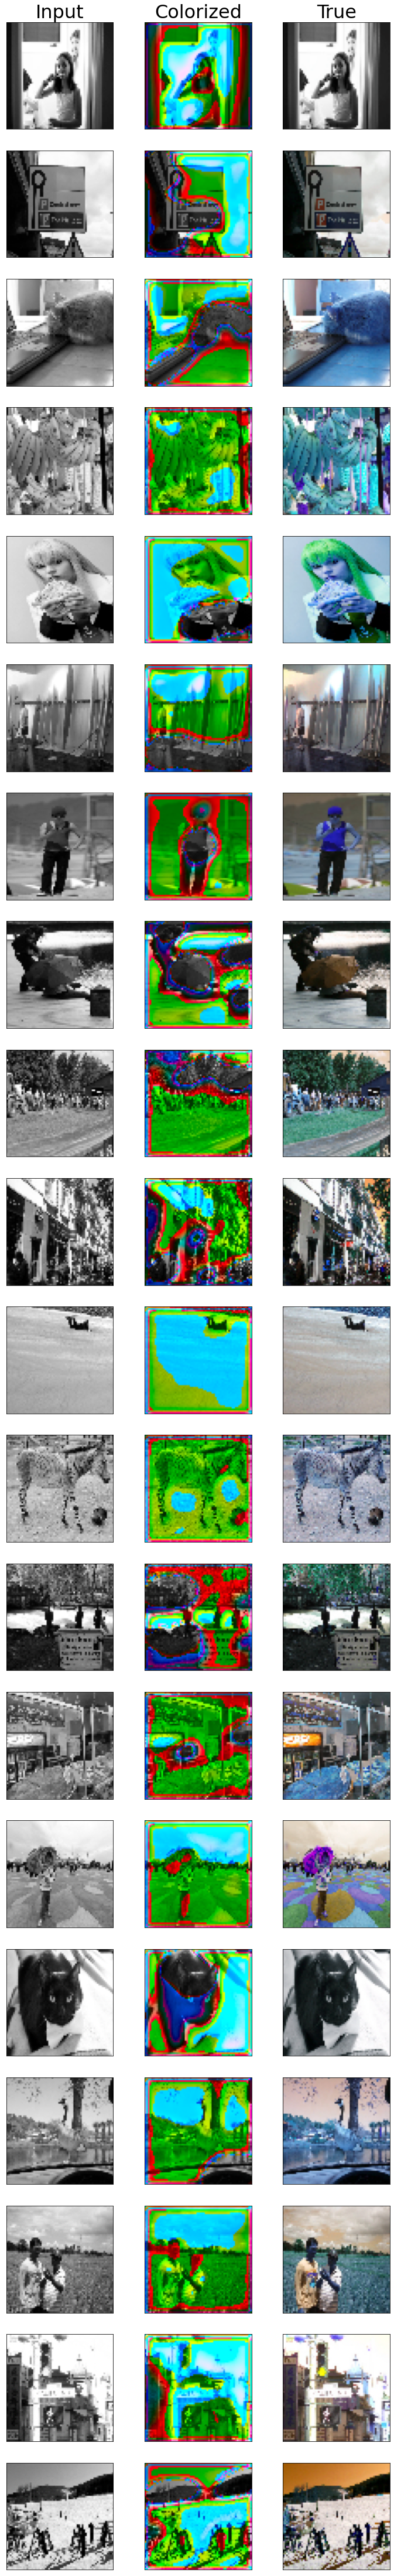

In [28]:
# Show test images
utils.display_images(
    generator=generator,
    X=X_test,
    y=y_test,
    count=20);